# COMP90051 Assignment 2 - Feature Engineering Pipeline

In [1]:
#importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import cv2

In [2]:
np.random.seed(66)

## Image Preparation

Loading images

In [3]:
#setting working directory
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset') #CHANGE THIS TO YOUR OWN DIRECTORY TO LOAD THE IMAGES
print(os.getcwd())

/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset


In [4]:
#loading image paths
data_dir = Path('.')

boot_images = list((data_dir / 'Boot').glob('*.jpg')) + list((data_dir / 'Boot').glob('*.png'))
sandal_images = list((data_dir / 'Sandal').glob('*.jpg')) + list((data_dir / 'Sandal').glob('*.png'))
shoe_images = list((data_dir / 'Shoe').glob('*.jpg')) + list((data_dir / 'Shoe').glob('*.png'))

In [5]:
#combining image paths, creating labels
image_paths = boot_images + sandal_images + shoe_images
all_labels = ['Boot'] * len(boot_images) + ['Sandal'] * len(sandal_images) + ['Shoe'] * len(shoe_images)

In [6]:
#loading background images from directory
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/COMP90051_A2') #set the working directory to the folder corresponding to the github repo
def load_background_pool_from_directory(background_dir='backgrounds', target_size=(224, 224)):
    bg_path = Path(background_dir)
    
    if not bg_path.exists():
        print(f"Directory {background_dir} not found!")
        return []
    
    # Find all images recursively
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(bg_path.glob(ext))  # Use glob instead of rglob if not in subdirectories
    
    print(f"Found {len(image_paths)} background images")
    
    backgrounds = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            #resize to standard size
            img = img.resize(target_size)
            img_array = np.array(img)
            backgrounds.append(img_array)
            print(f"Loaded: {path.name} - Shape: {img_array.shape}")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    print(f"\nSuccessfully loaded {len(backgrounds)} backgrounds")
    print(f"All backgrounds standardized to shape: {backgrounds[0].shape if backgrounds else 'N/A'}")
    return backgrounds

background_pool = load_background_pool_from_directory('backgrounds')

#change directory back to the one that contains the shoe images
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset')

Found 21 background images
Loaded: kwon-junho-lwmPOZ5nUfk-unsplash.jpg - Shape: (224, 224, 3)
Loaded: alex-tyson-RR9Muj8qpns-unsplash.jpg - Shape: (224, 224, 3)
Loaded: mitch-harris-cPZ21gvclO8-unsplash.jpg - Shape: (224, 224, 3)
Loaded: martin-van-maaren-l3WPo-bchxk-unsplash.jpg - Shape: (224, 224, 3)
Loaded: valenzo-susanto-0mBaqgMI80A-unsplash.jpg - Shape: (224, 224, 3)
Loaded: lynda-sanchez-UZZcLyvqXJs-unsplash.jpg - Shape: (224, 224, 3)
Loaded: daryl-han-omleEc6GqCQ-unsplash.jpg - Shape: (224, 224, 3)
Loaded: emmanuel-ben-paul-R_k6kaHhHnY-unsplash.jpg - Shape: (224, 224, 3)
Loaded: carl-raw-n3GDA7mZVyU-unsplash.jpg - Shape: (224, 224, 3)
Loaded: c-cai-L9FaRRzZGX8-unsplash.jpg - Shape: (224, 224, 3)
Loaded: angele-kamp--OQbUQce54k-unsplash.jpg - Shape: (224, 224, 3)
Loaded: ilker-ozmen-1gTlnR6EHzw-unsplash.jpg - Shape: (224, 224, 3)
Loaded: keith-misner-h0Vxgz5tyXA-unsplash.jpg - Shape: (224, 224, 3)
Loaded: alex-lvrs-Md6_qA-BMis-unsplash.jpg - Shape: (224, 224, 3)
Loaded: hal-gate

Creating train-test split

In [7]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, 
    all_labels, 
    test_size = 0.2, 
    stratify = all_labels,
    random_state = 66
)

print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

#checking class distribution (making sure train/test sets have the same proportion of each class)
from collections import Counter
print("\nTraining set distribution:", Counter(train_labels))
print("Test set distribution:", Counter(test_labels))

Training set: 12000 images
Test set: 3000 images

Training set distribution: Counter({'Boot': 4000, 'Sandal': 4000, 'Shoe': 4000})
Test set distribution: Counter({'Shoe': 1000, 'Sandal': 1000, 'Boot': 1000})


## Adding Distortions

### Distortion 1 - Occlusions

In [8]:
#this function creates a shoe mask, that tells us where the shoe is. we can do this, because all of our images are the shoe on a white background
def create_shoe_mask(image, threshold=240):
    """Identify shoe pixels (non-white pixels)"""
    return np.any(image < threshold, axis=-1)

In [9]:
#this function places a random rectangular/square occlusion on the image. it uses the shoe mask to ensure that at least part of the occlusions that is inserted, overlaps with the shoe itself
#INPUTS:
#occlusion_size - (height, width) of the rectangle
#shoe_mask - binary mask, where True = shoe pixel
def place_random_occlusion_on_shoe(image_array, occlusion_size, shoe_mask):
    #find shoe pixel coordinates
    shoe_coords = np.argwhere(shoe_mask)  # Returns [[y1,x1], [y2,x2], ...]
    
    #randomly pick a shoe pixel as anchor point
    anchor_idx = np.random.randint(len(shoe_coords))
    anchor_y, anchor_x = shoe_coords[anchor_idx]

    
    #set anchor to be center of rectangle
    y1 = anchor_y - occlusion_size[0] // 2
    x1 = anchor_x - occlusion_size[1] // 2
    
    y2 = y1 + occlusion_size[0]
    x2 = x1 + occlusion_size[1]
    
    #clip to image boundaries
    h, w = image_array.shape[:2]
    y1, y2 = max(0, y1), min(h, y2)
    x1, x2 = max(0, x1), min(w, x2)
    
    #apply occlusion (black rectangle)
    occluded_image = image_array.copy()
    occluded_image[y1:y2, x1:x2] = 0  # Black occlusion
    
    return occluded_image

In [10]:
#apply occlusion to an image given its file path
#INPUTS 
#image_array: numpy array of the image
#shoe_mask: binary mask, where True = shoe pixel
def apply_occlusion(image_array, shoe_mask):    
    #randomly select coverage percentage
    coverage_percentage = np.random.uniform(0.15, 0.45)
    
    #count total shoe pixels
    total_shoe_pixels = np.sum(shoe_mask)
    target_occluded_pixels = int(total_shoe_pixels * coverage_percentage)
    
    #calculate rectangle size needed
    rect_size = int(np.sqrt(target_occluded_pixels))
    
    #apply occlusion
    occluded_array = place_random_occlusion_on_shoe(image_array, (rect_size, rect_size), shoe_mask)
    
    return occluded_array.astype(np.uint8)

### Distortion 2 - Lighting

In [11]:
#function to apply combined lighting distortions (contrast, exposure and colour temperature)
#INPUTS: 
#   - image_array: numpy array of the image
#    - contrast_factor: float
#        < 1.0: low contrast (flat, washed out)
#        = 1.0: original
#        > 1.0: high contrast (harsh lighting)
#    - exposure_compensation: float in range [-3, +3]
#        Negative: underexposed (too dark)
#        0: original exposure
#        Positive: overexposed (too bright)
#    - temperature_shift: int (e.g., -50 to +50)
#        Negative: cooler (blue tint, outdoor/overcast)
#        0: neutral
#        Positive: warmer (orange tint, indoor/sunset)
#    RETURNS:
#    - numpy array with lighting distortions applied

def apply_lighting_distortion(image_array):
    # Randomly select parameters
    contrast_factor = np.random.uniform(0.5, 1.5)
    exposure_compensation = np.random.uniform(-1, 1)
    temperature_shift = np.random.uniform(-30, 30)
    
    img_array = image_array.astype(float)
    
    # 1. Apply contrast adjustment (numpy implementation)
    mean = np.mean(img_array)
    img_array = (img_array - mean) * contrast_factor + mean
    img_array = np.clip(img_array, 0, 255)
    
    # 2. Apply exposure compensation
    img_array = img_array / 255.0
    exposure_factor = 2 ** exposure_compensation
    img_array = img_array * exposure_factor
    img_array = np.clip(img_array, 0, 1)
    img_array = img_array * 255
    
    # 3. Apply color temperature shift
    if temperature_shift > 0:  # Warmer
        img_array[:, :, 0] = np.clip(img_array[:, :, 0] + temperature_shift, 0, 255)
        img_array[:, :, 1] = np.clip(img_array[:, :, 1] + temperature_shift * 0.5, 0, 255)
    else:  # Cooler
        img_array[:, :, 2] = np.clip(img_array[:, :, 2] - temperature_shift, 0, 255)
    
    return img_array.astype(np.uint8)

### Distortion 3 - Background Clutter

In [12]:
#this function adds background clutter to our image, by adding a background (image from the background pool)
#INPUTS:
#image - numpy array of shoe image
#background_pool - list of background images (all as numpy arrays)
#RETURNS:
#numpy array with shoe on new background
def add_background_clutter(image, background_pool):
    #get shoe mask
    shoe_mask = create_shoe_mask(image)
    
    #get background
    background = random.choice(background_pool)  # Randomly choose a background
    # Resize background to match shoe image size
    background = np.array(Image.fromarray(background).resize(
        (image.shape[1], image.shape[0])  # (width, height)
    ))
    background = background.copy()
    
    #add shoe back on top
    result = background.copy()
    result[shoe_mask] = image[shoe_mask]
    
    return result

### Distortion 4 - Rotation

In [13]:
def rotate(img):
    # rotate the image randomly between -30 to +30 degrees
    h, w = img.shape[:2]
    ang = random.uniform(-30, 30)
    M = cv2.getRotationMatrix2D((w//2, h//2), ang, 1)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

### Distortion 5 - Blur

In [14]:
def apply_blur(img):
    # apply blur (either Gaussian or motion) with random intensity
    choice = random.choice(["gaussian", "motion"])
    
    if choice == "gaussian":
        # Random kernel size between 3 and 9 (must be odd)
        kernel_size = random.choice([3, 5, 7, 9])
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    else:
        # Random motion blur length between 5 and 15
        k = random.choice([5, 7, 9, 11, 13, 15])
        kernel = np.zeros((k, k))
        kernel[k//2, :] = 1
        kernel /= k
        return cv2.filter2D(img, -1, kernel)

### Overall Distortion Function

This function combines the 3 distortion functions from above, to apply distortions to an image by first adding a noisy background, followed by applying lighting distortions, before finally adding occlusions

In [15]:
def augment_image(image_path, background_pool, selected_distortions):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image)
    
    # Rotation first if selected
    if 'rotation' in selected_distortions:
        image = rotate(image)
    
    # Create mask BEFORE background is added (whether rotated or not)
    shoe_mask = create_shoe_mask(image)
    
    # Now apply remaining distortions in order
    if 'background_clutter' in selected_distortions:
        image = add_background_clutter(image, background_pool)
    
    if 'lighting' in selected_distortions:
        image = apply_lighting_distortion(image)
    
    if 'occlusion' in selected_distortions:
        image = apply_occlusion(image, shoe_mask)
    
    if 'blur' in selected_distortions:
        image = apply_blur(image)
    
    return image

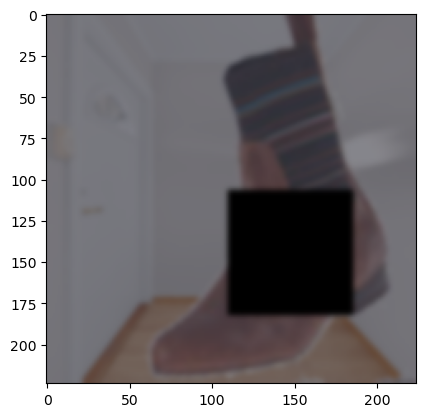

In [16]:
#example distorted image, applied to the first boot image
selected_distortions = ['rotation', 'background_clutter', 'lighting', 'occlusion', 'blur']
augmented = augment_image(boot_images[0], background_pool, selected_distortions)
plt.imshow(augmented)
plt.show()

## Feature Engineering Pipeline

Now that we have a working distortion function, we can construct our overall pipeline

In [17]:
#apply augmentations to a set of images
#INPUTS:
# image_paths - list of file paths to images
# labels - list of corresponding labels (shoe, boot, sandal)
# background_pool - list of background images
#RETURNS:
# X - numpy array of augmented images
# y - numpy array of labels
def augment_image_list(image_paths, labels, background_pool):
    augmented_images = []
    
    #available distortions
    all_distortions = ['rotation', 'background_clutter', 'lighting', 'occlusion', 'blur']
    
    print(f"Augmenting {len(image_paths)} images...")
    for i, img_path in enumerate(image_paths):
        if (i + 1) % 1000 == 0:  #progress indicator
            print(f"  Processed {i + 1}/{len(image_paths)}")
        
        #randomly select 3 out of 5 distortions
        selected_distortions = random.sample(all_distortions, 3)
        
        augmented_img = augment_image(img_path, background_pool, selected_distortions)
        augmented_images.append(augmented_img)
    
    X = np.array(augmented_images)
    y = np.array(labels)
    
    return X, y

In [18]:
# Training Set A: Original images (resized to consistent dimensions)
print("Creating Training Set A (original images)...")
X_train_A = []
for path in train_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))  
    X_train_A.append(np.array(img))
X_train_A = np.array(X_train_A)
y_train_A = np.array(train_labels)

# Training Set B: Augmented images
print("Creating Training Set B (augmented images)...")
X_train_B, y_train_B = augment_image_list(train_paths, train_labels, background_pool)

# Test Set: Augmented images
print("Creating Test Set (augmented images)...")
X_test, y_test = augment_image_list(test_paths, test_labels, background_pool)

print("\nDataset shapes:")
print(f"X_train_A: {X_train_A.shape}")
print(f"X_train_B: {X_train_B.shape}")
print(f"X_test: {X_test.shape}")

Creating Training Set A (original images)...
Creating Training Set B (augmented images)...
Augmenting 12000 images...
  Processed 1000/12000
  Processed 2000/12000
  Processed 3000/12000
  Processed 4000/12000
  Processed 5000/12000
  Processed 6000/12000
  Processed 7000/12000
  Processed 8000/12000
  Processed 9000/12000
  Processed 10000/12000
  Processed 11000/12000
  Processed 12000/12000
Creating Test Set (augmented images)...
Augmenting 3000 images...
  Processed 1000/3000
  Processed 2000/3000
  Processed 3000/3000

Dataset shapes:
X_train_A: (12000, 224, 224, 3)
X_train_B: (12000, 224, 224, 3)
X_test: (3000, 224, 224, 3)


Code below exports the augmented image sets above

In [19]:
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2') #CHANGE TO YOUR OWN FILEPATH, FOR WHERE YOU WANT TO SAVE THE DATA
print(os.getcwd())

/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2


In [20]:
output_dir = './augmented_data'
os.makedirs(output_dir, exist_ok=True)

# Save datasets as .npz files (compressed)
print("Saving datasets...")
np.savez_compressed(os.path.join(output_dir, 'train_A.npz'), 
                    X=X_train_A, y=y_train_A)
np.savez_compressed(os.path.join(output_dir, 'train_B.npz'), 
                    X=X_train_B, y=y_train_B)
np.savez_compressed(os.path.join(output_dir, 'test.npz'), 
                    X=X_test, y=y_test)

Saving datasets...
